In [2]:
from pathlib import Path
thispath = Path.cwd().resolve()
import sys; sys.path.insert(0, str(thispath.parent))

from general_utils.plots import plot_detections
from deep_learning.models.class_based_detector import ClassificationBasedDetector
from database.dataset import INBreast_Dataset

import torch
import pickle
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from torchvision import models

In [3]:
db = INBreast_Dataset(
    return_lesions_mask=True,
    level='image',
    max_lesion_diam_mm=None,
    extract_patches=False,
    partitions = ['validation'],
    lesion_types = ['calcification', 'cluster'],
    cropped_imgs = True,
    keep_just_images_of_lesion_type = False,
    use_muscle_mask=False,
    ignore_diameter_px = 15
)

In [4]:
# model definition
from collections import OrderedDict
activation = nn.ReLU()
dropout = 0.2
model = models.resnet18(pretrained=True)
n_inputs = model.fc.in_features
classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(n_inputs, 512)),
    ('act1', activation),
    ('do1', nn.Dropout(dropout)),
    ('fc2', nn.Linear(512, 512)),
    ('act2', activation),
    ('do2', nn.Dropout(dropout)),
    ('fc3', nn.Linear(512, 1))
]))
model.fc = classifier
model_path = thispath.parent/'data/example_model/try_02.p'
with open(model_path, 'rb') as f:
    best_model_wts = pickle.load(f)
model.load_state_dict(best_model_wts)
for param in model.parameters():
    param.requires_grad = False


# generic pipeline
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()
detector = ClassificationBasedDetector(
    model, threshold=0.03, post_proc=True, patch_size=224, stride=25,
    min_breast_fraction_patch=0.5, batch_size=24, device=device, nms=True,
    iou_threshold=0.2)

for i in range(1, len(db)):
    sample = db[i]
    img = sample['img']
    detections = detector.detect(img)
    break

100%|██████████| 220/220 [00:30<00:00,  7.10it/s]


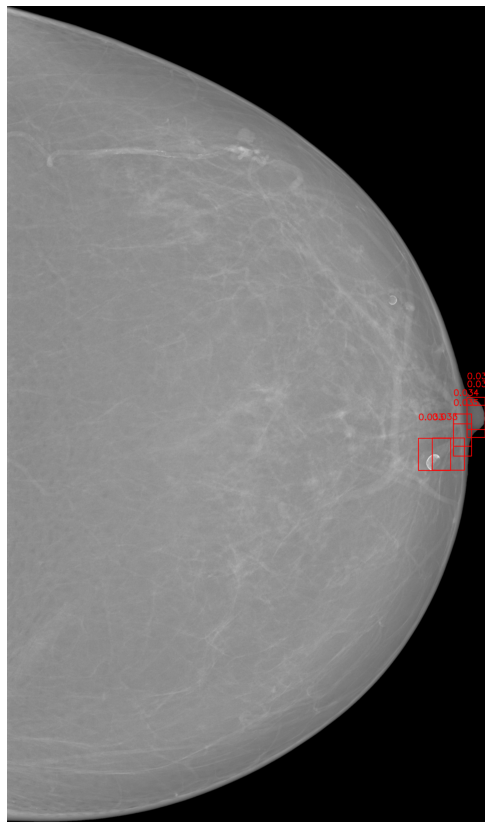

In [5]:
plot_detections(detections, img, k=50)

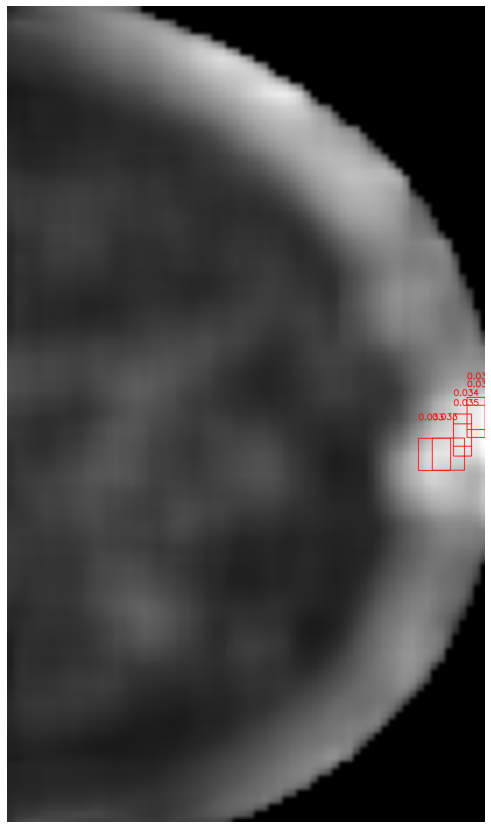

In [6]:
plot_detections(detections, detector.saliency_map, k=50)